In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
 def train_test_split(ratings_df, train_size=0.8):
    # Shuffle the ratings DataFrame
    data = shuffle(ratings_df)

    # Init ratio to split the data:
    ratio = int(train_size*len(data))

    # Split into train_set and test_set
    train_set = data[:ratio].reset_index().drop('index', axis=1)
    test_set = data[ratio:].reset_index().drop('index', axis=1)
    return train_set, test_set

def rmse(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.sqrt(np.mean((x1 - x2) ** 2))

In [3]:
# Load data
ratings_df = pd.read_csv('train-test-split/ratings.csv').drop('timestamp', axis=1)
train_df, test_df = train_test_split(ratings_df)

# Convert DataFrame to NumPy array 
ratings = ratings_df.pivot_table(values='rating', index='userId', columns='movieId').fillna(0).to_numpy()
train = np.zeros(ratings.shape)
test = np.zeros(ratings.shape)

for i in range(len(train_df)):
    train[train_df['userId'][i], train_df['movieId'][i]] = train_df['rating'][i]
for i in range(len(test_df)):
    test[test_df['userId'][i], test_df['movieId'][i]] = test_df['rating'][i]

In [4]:
class MF_SGD():
    def __init__(self, ratings, test, n_factors=40, n_epochs=20, reg_u=0, reg_i=0, reg_bu=0, reg_bi=0, eta=0.001, verbose=False):
        self.R = ratings # ratinngs matrix (train set)
        self.n_ratings = len(ratings[np.where(ratings != 0)]) # number of nonzero ratings
        self.user_idx, self.item_idx = ratings.nonzero() # user and item indices of nonzero ratings 
        self.n, self.m = ratings.shape # n: number of users, m: number of movies/items
        self.k = n_factors # number of latent factors
        self.n_epochs = n_epochs # number of epochs
        self.eta = eta # learning rate
        self.reg_u = reg_u # regularization for user
        self.reg_i = reg_i # regularization for item
        self.reg_bu = reg_bu # regularization for user bias
        self.reg_bi = reg_bi # regularization fot item bias
        self.mu = np.mean(ratings[np.where(ratings!=0)]) # global mean rating 
        self.verbose = verbose # whether or not to print out training progress
        
        # similar to training set but for test set
        self.R_test = test # ratings matrix
        self.n_ratings_test = len(test[np.where(test != 0)]) # number of nonzero ratings
        self.user_idx_test, self.item_idx_test = test.nonzero() # user and item indices of nonzero ratings
        
        self.rmse_train_list = [] # to store training loss
        self.rmse_test_list = [] # to store test loss
        
        # init factorized matrix (R =  U x M.T) 
        self.U = np.random.normal(scale=1/self.k, size=(self.n, self.k)) # n x k matrix
        self.M = np.random.normal(scale=1/self.k, size=(self.m, self.k)) # m x k matrix
        
        # init bias vector
        self.bu = np.zeros(self.n) # user bias
        self.bi = np.zeros(self.m) # item bias
        
    def predict(self, u, i):
        '''return prediction for R[u, i]'''
        return self.mu + self.bu[u] + self.bi[i] + self.U[u, :] @ self.M[i, :]
    
    def shuffle_indices(self):
        '''return an array of shuffled indices of nonzero ratings'''
        indices = shuffle(np.arange(self.n_ratings))
        return indices
    
    def sgd(self):
        for idx in self.shuffle_indices():
            u = self.user_idx[idx] # userId
            i = self.item_idx[idx] # itemId
            prediction = self.predict(u, i) # prediction of user u on item i
            e = self.R[u, i] - prediction # erorr between true rating and prediction
            
            
            # update biases
            self.bu[u] += self.eta * (e - self.reg_bu * self.bu[u])
            self.bi[i] += self.eta * (e - self.reg_bi * self.bi[i])
            
            # update vectors in U and M
            self.U[u, :] += self.eta * (e * self.M[i, :] - self.reg_u * self.U[u, :])
            self.M[i, :] += self.eta * (e * self.U[u, :] - self.reg_i * self.M[i, :])    
            
    def get_loss(self):
        # training set
        actual_rating = self.R[np.where(self.R != 0)]
        prediction = []
        for idx in range(self.n_ratings):
            u = self.user_idx[idx]
            i = self.item_idx[idx]
            prediction.append(self.predict(u, i))
        prediction = np.array(prediction)
        rmse_train = rmse(actual_rating, prediction)
        
        # test set
        actual_rating = self.R_test[np.where(self.R_test != 0)]
        prediction = []
        for idx in range(self.n_ratings_test):
            u = self.user_idx_test[idx]
            i = self.item_idx_test[idx]
            prediction.append(self.predict(u, i))
        prediction = np.array(prediction)
        rmse_test = rmse(actual_rating, prediction)
        
        return rmse_train, rmse_test
                
    def train(self):
        for epoch in range(self.n_epochs):
            self.sgd();
            rmse_train, rmse_test = self.get_loss()
            self.rmse_train_list.append(rmse_train)
            self.rmse_test_list.append(rmse_test)
            if self.verbose:
                print("epoch: " + str(epoch + 1) + "/" + str(self.n_epochs) + ", rmse_train: " + str(rmse_train) + ", rmse_test: " + str(rmse_test))

In [5]:
# Grid search to choose the best combination between parameters

# # Grid search
# latent_factors = [10, 20, 40, 80]
# epoch_list = [20, 50, 100, 200]
# eta_list = [0.001, 0.003, 0.01, 0.03]

# best_rmse = 1e10
# for k in latent_factors:
#     for n_epochs in epoch_list:
#         for eta in eta_list:
#             algo = MF_SGD(train, test, n_factors=k, n_epochs=n_epochs, eta = eta, verbose=False)
#             algo.train()
#             if algo.rmse_test_list[-1] < best_rmse:
#                 best_rmse = algo.rmse_test_list[-1]
#                 best_combination = (k, n_epochs, eta)
#             print("k = " + str(k) + ", n_epochs = " + str(n_epochs) + ", eta = " + str(eta) + ", rmse = " + str(algo.rmse_test_list[-1]))
# print("Best combination: k = " + str(best_combination[0]) + ", n_epochs = " + str(best_combination[1]) + ", eta = " + str(best_combination[2]) + ", rmse = " + str(best_rmse))

In [6]:
algo = MF_SGD(train, test, n_factors=40, n_epochs=200, eta=0.001, verbose=True)
algo.train()

epoch: 1/200, rmse_train: 0.9871728004364898, rmse_test: 0.9782966906185125
epoch: 2/200, rmse_train: 0.9621459622430338, rmse_test: 0.9555410823268129
epoch: 3/200, rmse_train: 0.9461593909418543, rmse_test: 0.9413915126519506
epoch: 4/200, rmse_train: 0.9346756285488149, rmse_test: 0.9315161053308927
epoch: 5/200, rmse_train: 0.9258439304476896, rmse_test: 0.9240443006052743
epoch: 6/200, rmse_train: 0.9187472777022273, rmse_test: 0.9182809348975987
epoch: 7/200, rmse_train: 0.9128569616230425, rmse_test: 0.913576742507233
epoch: 8/200, rmse_train: 0.907842345727701, rmse_test: 0.909672057156244
epoch: 9/200, rmse_train: 0.9034838217997387, rmse_test: 0.906341952118581
epoch: 10/200, rmse_train: 0.8996368101646826, rmse_test: 0.9034334559225757
epoch: 11/200, rmse_train: 0.8961968680443594, rmse_test: 0.9008810051241005
epoch: 12/200, rmse_train: 0.8930731473547786, rmse_test: 0.8987289135250787
epoch: 13/200, rmse_train: 0.8902366370945216, rmse_test: 0.8967675957811291
epoch: 14/20

epoch: 108/200, rmse_train: 0.7681909652516155, rmse_test: 0.860122759828735
epoch: 109/200, rmse_train: 0.766107007721171, rmse_test: 0.8599573258095783
epoch: 110/200, rmse_train: 0.7639987652453993, rmse_test: 0.8597908074461513
epoch: 111/200, rmse_train: 0.7618636862675943, rmse_test: 0.8596315301476286
epoch: 112/200, rmse_train: 0.7597035836891796, rmse_test: 0.8594509623886994
epoch: 113/200, rmse_train: 0.757519814587938, rmse_test: 0.8593265908392048
epoch: 114/200, rmse_train: 0.7553123356282403, rmse_test: 0.8591697570819972
epoch: 115/200, rmse_train: 0.7530836900692834, rmse_test: 0.8590391527615202
epoch: 116/200, rmse_train: 0.7508308321770487, rmse_test: 0.8589113758317417
epoch: 117/200, rmse_train: 0.7485599561381301, rmse_test: 0.8588070335318752
epoch: 118/200, rmse_train: 0.7462673357010862, rmse_test: 0.8586641330146453
epoch: 119/200, rmse_train: 0.7439583547624027, rmse_test: 0.8585529797975834
epoch: 120/200, rmse_train: 0.7416288406184784, rmse_test: 0.858451

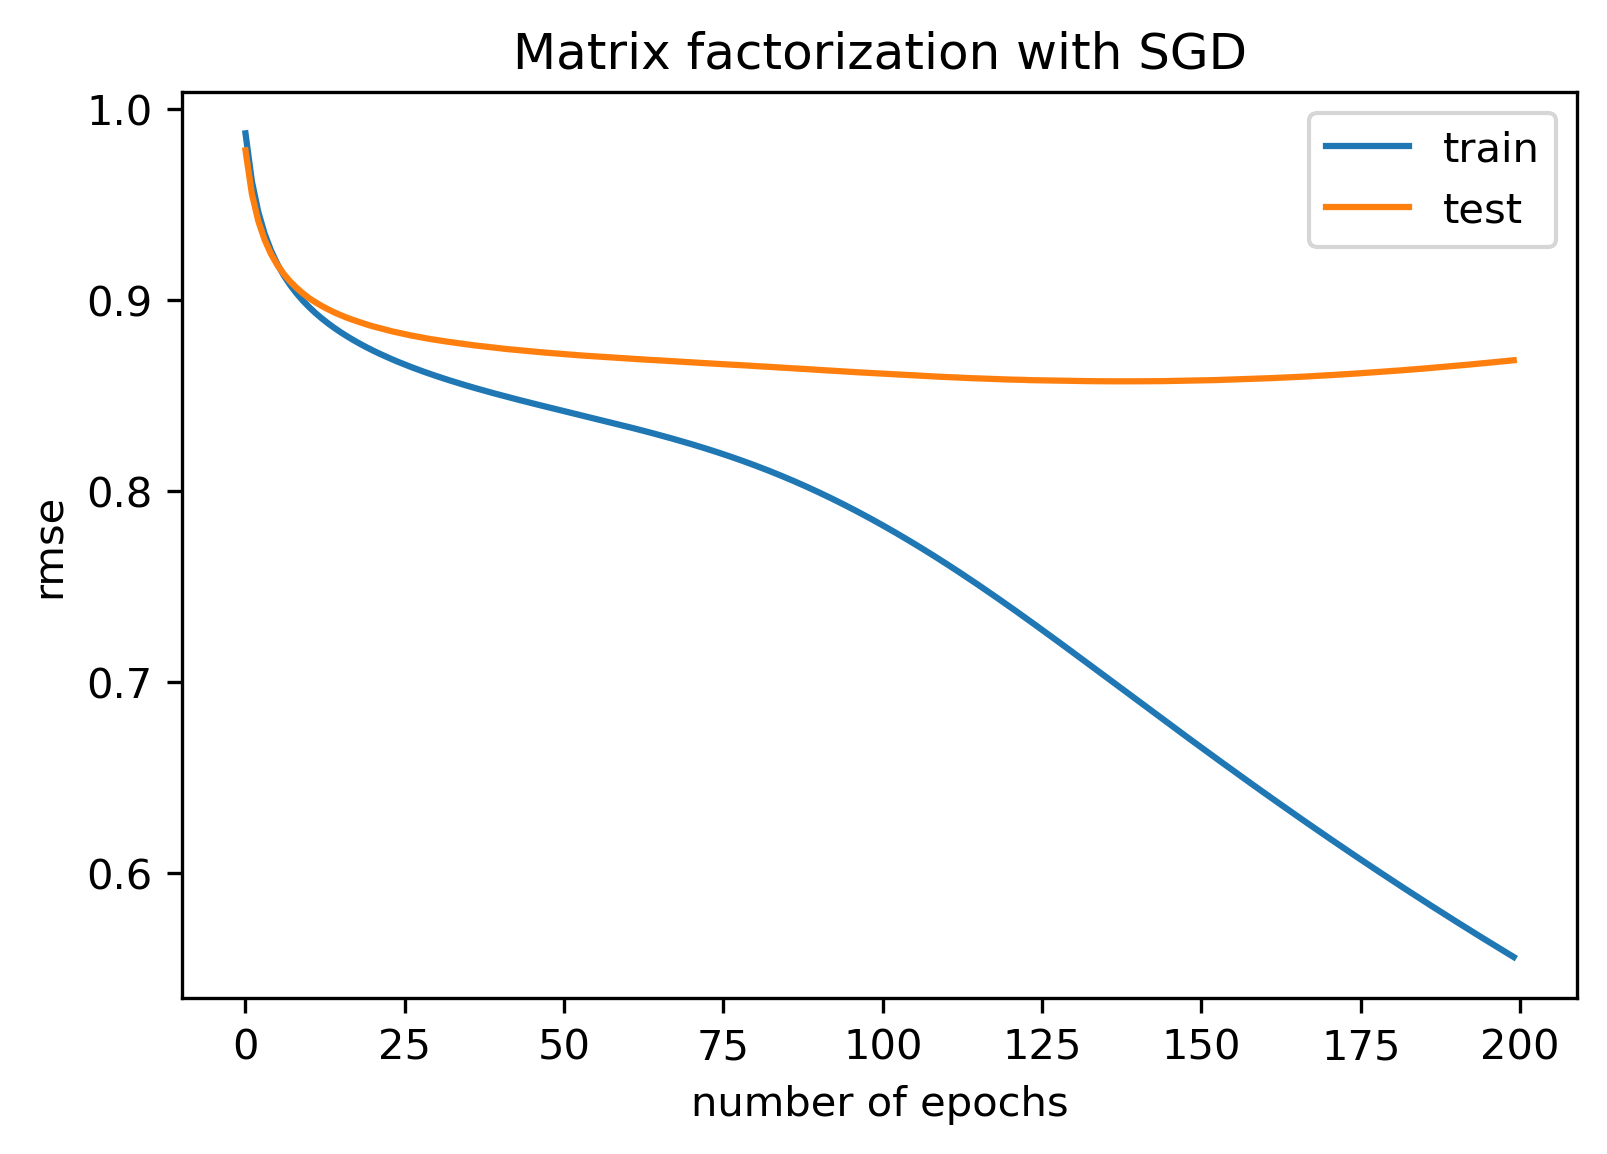

In [7]:
plt.figure(dpi=300)
x_range = range(len(algo.rmse_test_list))
plt.plot(x_range, algo.rmse_train_list)
plt.plot(x_range, algo.rmse_test_list)
plt.xlabel("number of epochs")
plt.ylabel("rmse")
plt.legend(["train", "test"])
plt.title("Matrix factorization with SGD")
plt.show()